# Maximum Entropy null-models of Regional Freight

Using ETISplus database.

*  undirected gravity model [UGM](#UGM)
* [UWCM](#UWCM)
* [UBCM](#UBCM)
* [DBCM](#DBCM)
* [UDCGM](#UDCGM)
* [distUBCM](#Distance-modulated-Undirected-Binary-Configuration-Model) Distance Modulated Undirected Binary CM
* distUBCM + weight: [distUBCM-+UDCGM](#distUBCM-+UDCGM) [distUBCM+UECM](#distUBCM+UECM)
* [FiUGM](#FiUGM-Fitness-Induced-Undirected-Gravity-Model)
* [UECM](#UECM)
* [UEGM](#UEGM)

Data:

  * https://ftp.demis.nl/outgoing/etisplus/datadeliverables/
  * old: http://etisplus.eu, https://ftp.demis.nl

Refs:

   * [Mastrandrea et al 14] Enhanced reconstruction of weighted networks from strengths and degrees http://dx.doi.org/10.1088/1367-2630/16/4/043022
   * [Almog et al 15] Almog, Bird, Garlaschelli "Enhanced Gravity Model of trade: reconciling macroeconomic and network models" arxiv:1506.00348
   * [Bianconi et al.09] Bianconi, Pin Marsili, "Assessing the relevance of node features for network structure"    PNAS 106, 11433 (2009).[pnas](http://www.pnas.org/content/early/2009/06/30/0811511106.full.pdf)
   * [Ruzzenenti et al.12] Ruzzenenti et al "Spatial effects in real networks: measures, null models, and applications" arxiv:1207.1791
   * ESANN17 [hal](https://hal.archives-ouvertes.fr/hal-01500352/), [github](https://github.com/Yquetzal/spaceCorrectedLouvainDC)
      *  cited by S.Lhomme Laburba [hal](https://hal.archives-ouvertes.fr/hal-01649121)
   * [Squartini et al. 14] in "Jan Tinbergen’s Legacy for Economic Networks: From the Gravity Model to Quantum Statistics" in F. Abergel et al. (eds.), Econophysics of Agent-Based models,New Economic Windows, DOI 10.1007/978-3-319-00023-7_9   
   * [Squartini et al.16] "network reconstruction via density sampling" arxiv:1610.05494
   

In [2]:
from region_freight import *

#from city_mrio import *
from cfg import *
from tools import convert_ig_to_nx
from measure import basic_stats_ig, link_overlap

import cm_ml.cm as cm_cy
from cm_ml.cmtools import *
from cm_ml.cmtools_spatial import *
from cm_ml.dataset import *

from scipy import stats
#%matplotlib notebook  
%matplotlib inline

import matplotlib.colors as mcolors

plt.rc('font',size=17)

## Load dataset

In [3]:
tra_type= 'rail'
year='2010'
d = load_etisplus(year=year,geodata=True, data_src='observed', directed=False)
D = get_distance_matrix(d,tra_type='rail')

print(d['rail'].summary())
print(d['rail'].density())
print(d['sea'].summary())
print(d['sea'].density())

/home/aurelien/local/git/mplex/region_freight.py:137: UserWarning: has loop
  loop=True;  warnings.warn('has loop')
/home/aurelien/local/git/mplex/region_freight.py:139: UserWarning: has multiple
  multiple=True; warnings.warn('has multiple')


IGRAPH UNW- 289 7248 -- 
+ attr: name (v), weight (e)
0.17416378316032297
IGRAPH UNW- 171 2190 -- 
+ attr: name (v), weight (e)
0.15067079463364294


 ## UGM

Undirected gravity model, **no spatial information** is used.

In [10]:
# undirected
g = d[tra_type]
A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)
W = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute='weight', default=0, eids=False)
W = np.array(W.data)
s = np.array(g.strength(weights="weight"))
k=np.array(g.degree())
# GM
W_GM= wij_UGM(s)
# weighted ANND
wknn_ = wknn(W,s)
wknn_GM = wknn(W_GM,s)

/home/aurelien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Text(0, 0.5, '$w_{ij}^{GM}$')

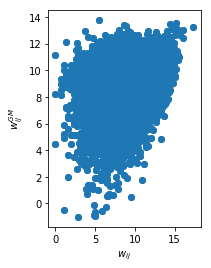

In [108]:
# plot weights
plt.subplot(1,2,1)
#plt.scatter(W.flatten(), W_GM.flatten())
plt.scatter(np.log(W.flatten()), np.log(W_GM.flatten()))
plt.xlabel('$w_{ij}$')
plt.ylabel('$w_{ij}^{GM}$')
#x=1e6
#plt.plot([0,x],[0,x],'r--')
#plt.xlim([0,x])

Commentaire:
    
   * fit pas bon même en coordonnées log-log.

<IPython.core.display.Javascript object>


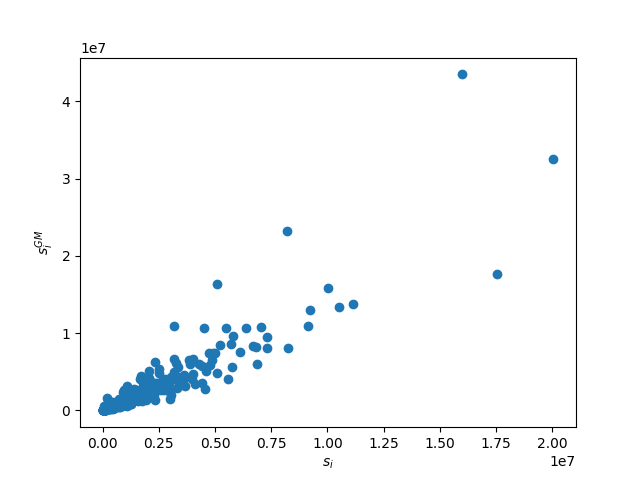

In [30]:
plt.scatter(np.sum(W,axis=0), np.sum(W_GM,axis=0))
plt.xlabel('$s_{i}$')
plt.ylabel('$s_{i}^{GM}$')
plt.show()

<IPython.core.display.Javascript object>


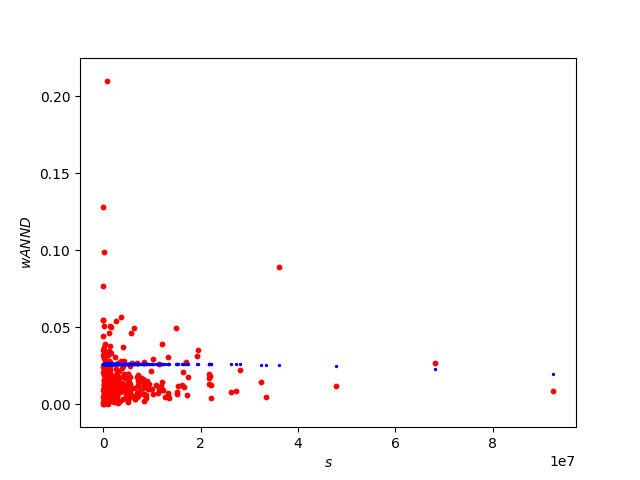

In [31]:
#plot nearest-neighbour 
plt.scatter(s,wknn_,c='r',s=10)
plt.scatter(s,wknn_GM,c='b', s=2)
    
plt.xlabel("$s$")
plt.ylabel("$wANND$")
plt.show()


Commentaire:
    
   * les $w_{ij}$ sont mal modélisés
   * les $s_{i}$ sont correctement reproduits. OK.
   * wANND est surestimé par le modèle. OK.

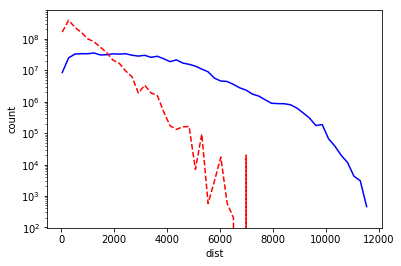

In [14]:
# histogram count(wij_sample)=f(dist), vs real data
# see [Kaluza et al. 10]
nbins=50
D_= D+D.transpose()
class_dij,B_d,bin_edges = get_classes(D_,A,bins=nbins)

classes = np.sort(np.unique(class_dij))
#discard -1
classes = classes[classes>=0]
W_GM_3d = np.zeros((W.shape[0],W.shape[0],1))
W_GM_3d[:,:,0]=W_GM
histbydij = hist_by_dij(class_dij,W_GM_3d,classes)
wij_3d = np.zeros((W.shape[0],W.shape[0],1))
wij_3d[:,:,0]=W; histbydij_ = hist_by_dij(class_dij,wij_3d,classes)

#plt.plot(bin_edges[:-1], histbydij,'b')
#plt.plot(bin_edges[:-1], histbydij_,'r--')
plt.semilogy(bin_edges[:-1], histbydij,'b')
plt.semilogy(bin_edges[:-1], histbydij_,'r--')

plt.xlabel('dist')
plt.ylabel('count')
plt.show()

## UWCM

## UBCM

In [9]:
g = d[tra_type]
A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)

W = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute='weight', default=0, eids=False)
W = np.array(W.data)
s = np.array(g.strength(weights="weight"))
k=np.array( A.sum(axis=0))

sol = solve_eq_UBCM(k,method='lm')	
if sol.success:
    P = pij_UBCM(sol.x)
else: raise ValueError('fit failed')

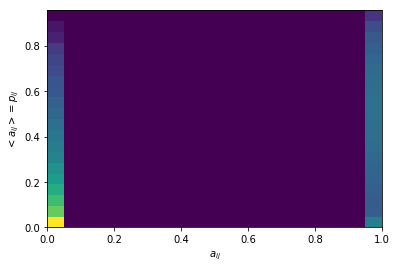

Text(0.5, 0, '$p_{ij}|a_{ij}=1$')

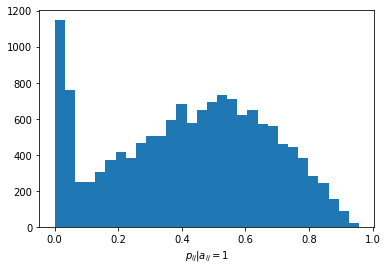

In [10]:
#plt.scatter( np.log(W_resc.flatten() ), np.log(wij_avg.flatten()) ) ; 
gamma=0.3
plt.hist2d(A.flatten(),P.flatten(),bins=20,norm=mcolors.PowerNorm(gamma))
plt.xlabel("$a_{ij}$")
plt.ylabel("$<a_{ij}>=p_{ij}$")
plt.show()
idx_nnz = A.flatten()>0
plt.hist(P.flatten()[idx_nnz],30 )
plt.xlabel('$p_{ij}|a_{ij}=1$')

In [42]:
# knn: theoretical
k_th = k_avg_UBCM(P)
knn_th = knn_avg_UBCM(P,k_th)
# knn: empirical
#knn = np.array(g.knn()[0])  
knn = knn_avg_UBCM(A,k)

# knn_sigma
nsamp=30
n = P.shape[0]
rnd = np.random.rand(n*n*nsamp).reshape((n,n,nsamp))
A_samp=samples_UBCM(P, rnd)
knn_sigma = knn_sigma_sample(A_samp)


<IPython.core.display.Javascript object>


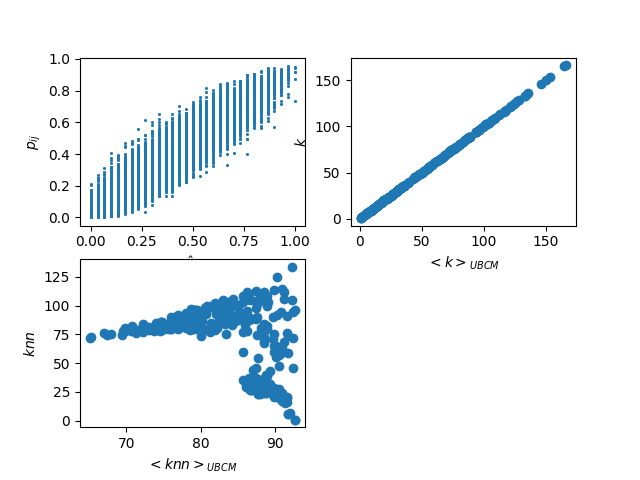

In [43]:
# plot k=f(k_th)
plt.subplot(2,2,1)
#plt.scatter(A.flatten(), P.flatten(),s=1)
plt.scatter(np.mean(A_samp,axis=2).flatten(), P.flatten(),s=1)
plt.xlabel('$\hat{a}_{ij}$')
plt.ylabel('$p_{ij}$')
plt.subplot(2,2,2)
plt.scatter(k_th,k)
plt.xlabel('$<k>_{UBCM}$')
plt.ylabel('$k$')
plt.subplot(2,2,3)
plt.scatter(knn_th,knn)
plt.xlabel('$<knn>_{UBCM}$')
plt.ylabel('$knn$')
plt.show()

<IPython.core.display.Javascript object>


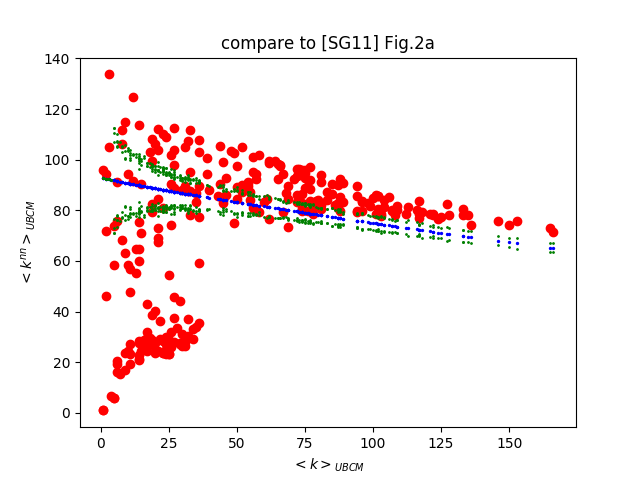

In [44]:
# plot knn=f(k)
plt.scatter(k,knn,c='r'  )
plt.scatter(k_th,knn_th,c='b',s=2)
plt.scatter(k_th,knn_th+knn_sigma,c='g',s=1)
plt.scatter(k_th,knn_th-knn_sigma,c='g',s=1)

plt.xlabel('$<k>_{UBCM}$')
#plt.ylabel('$\langle k^{nn} \rangle_{UBCM}$')
plt.ylabel('$< k^{nn} >_{UBCM}$')
plt.title('compare to [SG11] Fig.2a')
plt.show()

Commentaire: 
    
   * $p$ est bon, $k$ est bon
   * $k^{nn}$ pas mal sauf le nuage du bas.

## DBCM

In [6]:
d_dir = load_etisplus(year=year,geodata=True, data_src='observed', directed=True)
g = d_dir[tra_type]
A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
    
kin  = np.sum(A,axis=0)
kout = np.sum(A,axis=1)    
nin = kin.shape[0]
nout = kout.shape[0]
sol = solve_eq_DBCM(kin,kout)
# fit DRGM ..
# fit DRCM ..
assert sol.success
P = pij_DBCM(sol.x,nout,nin)
P=np.clip(P,0,1)
    
kin_DBCM  = np.sum(P,axis=0)
kout_DBCM = np.sum(P,axis=1)
assert np.all(P>=0) and np.all(P<=1) 


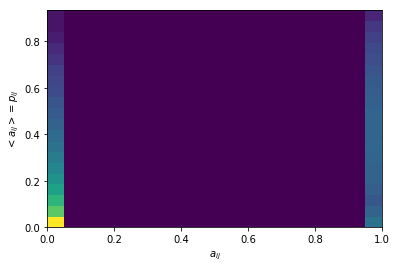

In [10]:
#plt.scatter( np.log(W_resc.flatten() ), np.log(wij_avg.flatten()) ) ; 
gamma=0.3
plt.hist2d(A.flatten(),P.flatten(),bins=20,norm=mcolors.PowerNorm(gamma))
plt.xlabel("$a_{ij}$")
plt.ylabel("$<a_{ij}>=p_{ij}$")
plt.show()


In [4]:
# global measures
F_avg =F(P,D)
print(F_avg)
phi_ = phi(A,P,D,ensemble='default')
print(phi_)

8372941.694176929
-0.10734180512312948


Comments:
    
   *  network is "shrunk". Distances play a role ($\phi=0$ means distance do not play a role).
   *  Value $\phi=-0.10$ close to the one of the WTN in 2000.
   *  we expect this will be reflected in local measures.

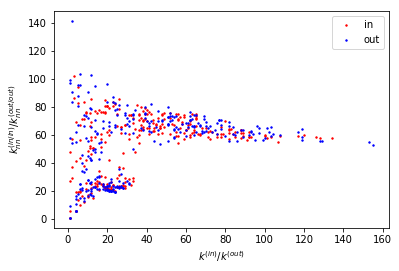

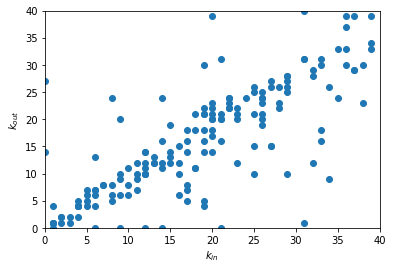

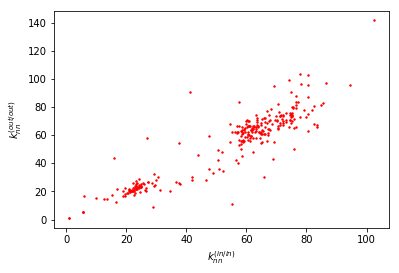

In [24]:
#knn_in = np.array(g.knn()[0]) 
knn_in_in,knn_out_out = assortativity(A,kin,kout,k_in=kin,k_out=kout)

plt.scatter(kin,knn_in_in,c='r',s=2, label='in');
#plt.xlabel('$k^{(in)}$')
#plt.ylabel('$k_{nn}^{(in/in)}$')
#plt.show()
plt.scatter(kout,knn_out_out,c='b',s=2, label='out');
plt.xlabel('$k^{(in)} / k^{(out)}$')
plt.ylabel('$k_{nn}^{(in/in)} / k_{nn}^{(out/out)}$')
plt.legend()
plt.show()

plt.scatter(kin,kout)
plt.xlabel('$k_{in}$')
plt.ylabel('$k_{out}$')
plt.xlim([0,40]); plt.ylim([0,40]);
plt.show()

plt.scatter(knn_in_in,knn_out_out,c='r',s=2, label='in');
plt.xlabel('$k_{nn}^{(in/in)} $')
plt.ylabel('$k_{nn}^{(out/out)}$')
plt.show()

Commentaires:
    
   * same behavior for $k_{nn}=f(k)$ whether in/in or out/out
   * low kin and low kout: highly correlated
   * low knn in/in and low knn out/out: highly correlated, two regions.
   

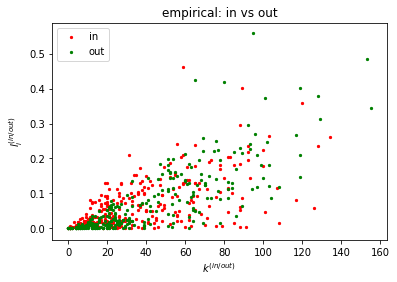

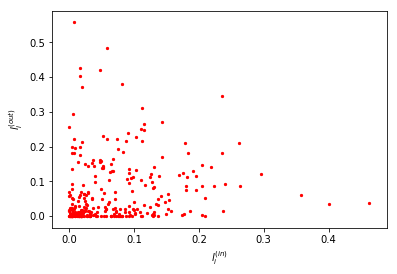

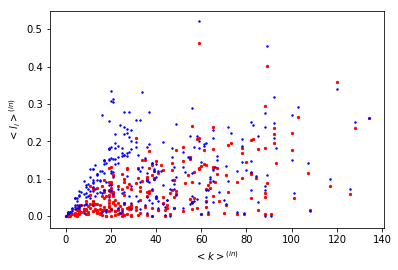

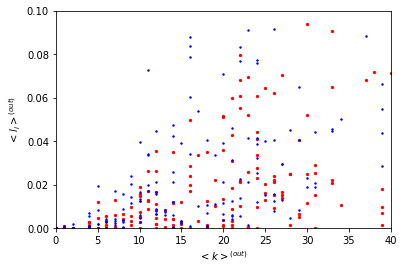

In [13]:

# local measure: $l_i$
l_i_in, l_i_out = l_i(A,D) 
l_i_in_DBCM, l_i_out_DBCM = l_i(P,D) 
# plot: in vs out
plt.scatter(kin,l_i_in,c='r',s=5, label='in');
plt.scatter(kout,l_i_out,c='g',s=5, label='out');
plt.xlabel('$k^{(in/out)}$')
plt.ylabel('$l_i^{(in/out)}$')
plt.title('empirical: in vs out')
#plt.xlim([0,40]); plt.ylim([0,0.1]);
plt.legend()
plt.show()
# plot: l_i_in vs l_i_out
plt.scatter(l_i_in,l_i_out,c='r',s=5, label='in');
plt.xlabel('$l_i^{(in)}$')
plt.ylabel('$l_i^{(out)}$')
#plt.xlim([0,.1]); plt.ylim([0,0.1]);
plt.show()
# plot: empirical vs model
plt.scatter(kin,l_i_in,c='r',s=5);
plt.scatter(kin_DBCM,l_i_in_DBCM,c='b',s=2);
plt.xlabel('$<k>^{(in)}$')
plt.ylabel('$<l_i>^{(in)}$')
plt.show()
plt.scatter(kout,l_i_out,c='r',s=5);
plt.scatter(kout_DBCM,l_i_out_DBCM,c='b',s=2);
plt.xlabel('$<k>^{(out)}$')
plt.ylabel('$<l_i>^{(out)}$')
plt.xlim([0,40]); plt.ylim([0,0.1]);
plt.show()

/home/aurelien/local/git/cm_ml/cmtools_spatial.py:135: RuntimeWarning: invalid value encountered in true_divide
  A_out = A_out/ k_out
/home/aurelien/local/git/cm_ml/cmtools_spatial.py:137: RuntimeWarning: invalid value encountered in true_divide
  A_in = A_in/ k_in


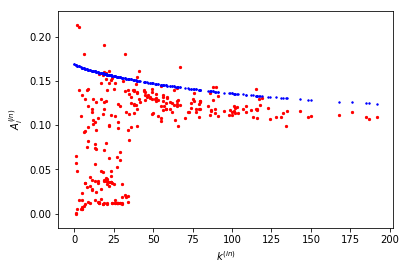

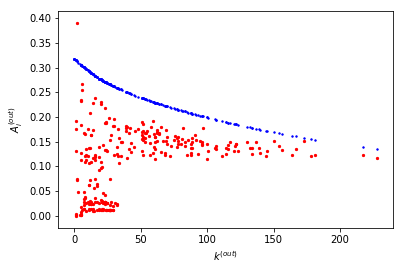

In [7]:
# local measure: assortativity    
A_in,A_out = assortativity(A,l_i_in,l_i_out,k_in=kin,k_out=kout)
A_in_DBCM,A_out_DBCM = assortativity(P,l_i_in_DBCM,l_i_out_DBCM,
                            k_in=kin_DBCM,k_out=kout_DBCM)
# plot    
plt.scatter(kin,A_in,c='r',s=5);
plt.scatter(kin_DBCM,A_in_DBCM,c='b',s=2);
plt.xlabel('$k^{(in)}$')
plt.ylabel('$A_i^{(in)}$')
plt.show()
plt.scatter(kout,A_out,c='r',s=5);
plt.scatter(kout_DBCM,A_out_DBCM,c='b',s=2);
plt.xlabel('$k^{(out)}$')
plt.ylabel('$A_i^{(out)}$')
plt.show()

Comments:
    
   *  $l_i=f(k_i)$:
       * model values above experimental values. Consistent with global $\phi<0$
       * which contribute most:  small $k$ for $l_{in}$ vs high $k$ for $l_{out}$. INTERPRETATION ?
       * difference in/out ?
   *  $A_i=f(k_i)$ 
       *  both curves above the cloud. (Not global value to compare to, similar to $\phi / l_i$ comparison). Low $k$ contribute most to the gap between the model and experimental values.
       *  the low k/low region of $A_i$ is not well reproduced.

## UDCGM

No distance here. [Squartini et al.16] 

Undirected degree-corrected gravity model

In [15]:
g = d[tra_type]
A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)
W = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute='weight', default=0, eids=False)
W = np.array(W.data)
s = np.array(g.strength(weights="weight"))
k=np.array(A.sum(axis=0))

n = s.shape[0]
sol=solve_UDCGM(s,k=k,z0=0.,method='hybr')#,jac=ficm_cy._jac_DCGM)
print(sol)
assert sol.success

z = sol.x[0]
P = pij_UDCGM(s,z)

# sample
wij_sample = sample_wij_UDCGM(P,s,nsamp=300,correction=True)
aij_sample = 1.*(wij_sample>0)
aij_avg = aij_avg_UDCGM(wij_sample)
wij_avg= wij_avg_UDCGM(wij_sample)
k_avg = np.sum(aij_avg,axis=0)	
s_avg = np.sum(wij_avg,axis=0)
snn_avg = snn(P,k_avg,s_avg)

# knn
knn_avg = knn_avg_UBCM(P,k_avg)
knn_sigma = knn_sigma_sample(aij_sample,directed=False)
# snn
snn_sigma = snn_sigma_sample(wij_sample,directed=False)

/home/aurelien/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: multiple edge
  """
/home/aurelien/local/git/cm_ml/cmtools.py:238: RuntimeWarning: divide by zero encountered in true_divide
  Wij = (Wij+Wij_correc)/P


    fjac: array([[-1.]])
     fun: 7.275957614183426e-12
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-5.41513145e-09])
       r: array([-4.60872203e+17])
  status: 1
 success: True
       x: array([1.7217938e-14])


/home/aurelien/local/git/cm_ml/cmtools.py:909: RuntimeWarning: divide by zero encountered in true_divide
  snn = snn/k
/home/aurelien/local/git/cm_ml/cmtools.py:909: RuntimeWarning: invalid value encountered in true_divide
  snn = snn/k


<IPython.core.display.Javascript object>


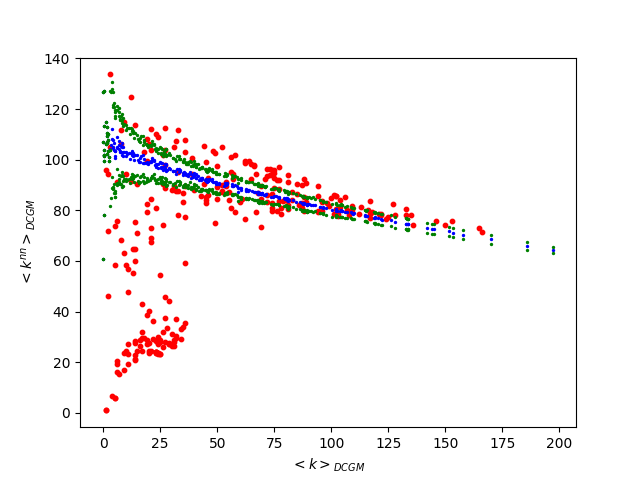

In [16]:
knn_= knn_avg_UBCM(A,k) 
#knn_= g.knn()[0]
plt.scatter(k,knn_, c='r',s=10 )
plt.scatter(k_avg, knn_avg, c='b',s=2)
plt.scatter(k_avg, knn_avg+knn_sigma, c='g',s=2)
plt.scatter(k_avg, knn_avg-knn_sigma, c='g',s=2)

plt.xlabel('$<k>_{DCGM}$')
plt.ylabel('$< k^{nn} >_{DCGM}$')
#plt.title('compare to [SG17] 4.3.2, Fig. 4.14')

plt.show()


<IPython.core.display.Javascript object>


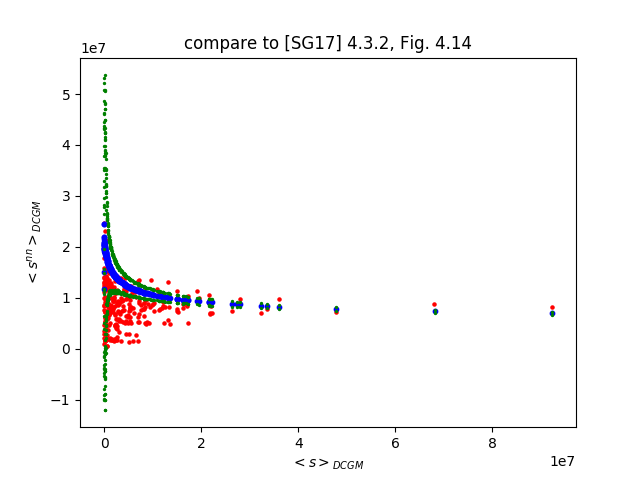

In [21]:
snn_ = snn(A,k,s)
#plt.semilogy(s,snn_  , 'ro',markersize=10 ) 
log = False
if log:
    plt.semilogy(s,snn_  , 'ro',markersize=5 ) 
    plt.semilogy(s_avg, snn_avg , 'b.',markersize=10 ) 
    plt.semilogy(s_avg, snn_avg+snn_sigma, 'g.',markersize=2 ) 
    plt.semilogy(s_avg,snn_avg-snn_sigma , 'g.',markersize=2 ) 
else:
    plt.scatter(s,snn_  , c='r',s=5) 
    plt.scatter(s_avg, snn_avg , c='b',s=10 ) 
    plt.scatter(s_avg, snn_avg+snn_sigma, c="g", s=2 ) #'g.',
    plt.scatter(s_avg,snn_avg-snn_sigma , c='g',s=2 ) 
plt.xlabel('$<s>_{DCGM}$')
plt.ylabel('$< s^{nn} >_{DCGM}$')
plt.title('compare to [SG17] 4.3.2, Fig. 4.14')
#plt.xlim([-1,600])
#plt.ylim([35,60])
plt.show()

<IPython.core.display.Javascript object>


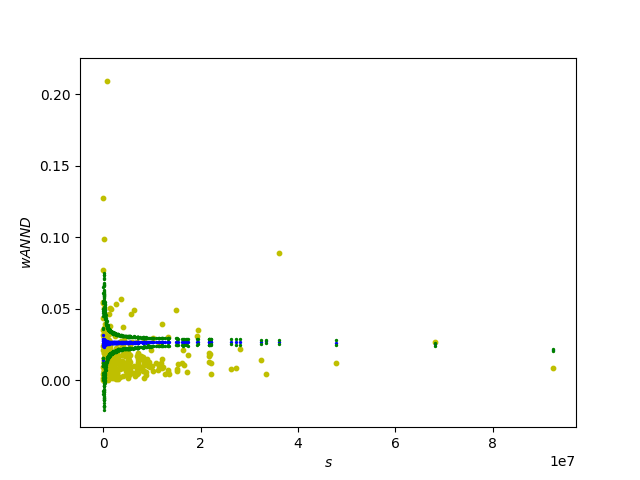

In [48]:
wknn_ = wknn(W,s)

wknn_theor = wknn(wij_avg,s)
 
wknn_sigma = wknn_sigma_sample(wij_sample,directed=False)    

#plt.scatter(s,wknn_,c='r',s=10)
plt.scatter(s,wknn_,c='r',s=10)

plt.scatter(s,wknn_theor,c='b',s=2)
plt.scatter(s, wknn_theor+wknn_sigma,c='g',s=2)
plt.scatter(s, wknn_theor-wknn_sigma,c='g',s=2)
plt.xlabel("$s$")
plt.ylabel("$wANND$")
plt.show()

Commentaire: 
    
   * si on ne regarde pas le nuage avec knn faible, le modèle peut être satisfaisant pour $k^{nn}$ 
   * mais $s^{nn}$ et $wknn$ surestiment clairement les valeurs pour le bulk mais est ok pour $s$ élevé. Comparer à EGM qui fait mieux pour le bulk, mais moins bien pour $s$ élevé.
     * Q: pourquoi.

# UDCGMmod

Here $k$ is used instead of $s$
(in the original DCGM, only $L$ and $s$ are known, not $k$).

In [4]:
g = d[tra_type]
A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)
W = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute='weight', default=0, eids=False)
W = np.array(W.data)
s = np.array(g.strength(weights="weight"))
k=np.array(A.sum(axis=0))

n = s.shape[0]
sol=solve_UDCGM(k.astype(np.float),k=k,z0=0.,method='hybr')# k is used instead of s here !!!!!!
print(sol)
assert sol.success

z = sol.x[0]
P = pij_UDCGM(k,z) # k is used instead of s here !!!!!!

# sample
nsamp=300
wij_sample = sample_wij_UDCGM(P,s,nsamp=nsamp,correction=True) # s is used here
aij_sample = 1.*(wij_sample>0)
aij_avg = aij_avg_UDCGM(wij_sample)
wij_avg= wij_avg_UDCGM(wij_sample)
k_avg = np.sum(aij_avg,axis=0)	
s_avg = np.sum(wij_avg,axis=0)
snn_avg = snn(P,k_avg,s_avg)

# knn
knn_avg = knn_avg_UBCM(P,k_avg)
knn_sigma = knn_sigma_sample(aij_sample,directed=False)
# snn
snn_sigma = snn_sigma_sample(wij_sample,directed=False)

/home/aurelien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: multiple edge
  """


    fjac: array([[-1.]])
     fun: -8.549250196665525e-10
 message: 'The solution converged.'
    nfev: 15
     qtf: array([8.13550287e-07])
       r: array([-97278773.28295182])
  status: 1
 success: True
       x: array([0.00010488])


In [11]:
ki_sample= sample_k_UDCGM(aij_sample,nsamp, naive=False)
knn_sample = sample_knn_UDCGM(aij_sample,ki_sample,nsamp)
knn_=knn_avg_UBCM(A,k)



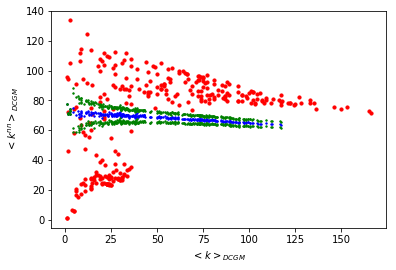

In [5]:
#knn_= g.knn()[0]
plt.scatter(k,knn_, c='r',s=10 )
plt.scatter(k_avg, knn_avg, c='b',s=2)
plt.scatter(k_avg, knn_avg+knn_sigma, c='g',s=2)
plt.scatter(k_avg, knn_avg-knn_sigma, c='g',s=2)

plt.xlabel('$<k>_{DCGM}$')
plt.ylabel('$< k^{nn} >_{DCGM}$')
#plt.title('compare to [SG17] 4.3.2, Fig. 4.14')

plt.show()

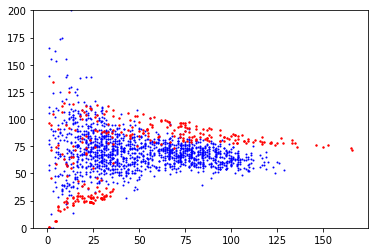

In [17]:
plt.scatter(ki_sample[:,0:5].flatten(),knn_sample[:,0:5].flatten(),c='b',s=1)
plt.scatter(k,knn_, c='r',s=2 )
plt.xlabel('$k_{samp}$')
plt.ylabel('$k^{nn}_{samp}$')
plt.ylim([0,200])
plt.show()

# UDCGM mod+ spatial

# Distance-modulated Undirected Binary Configuration Model

For topology only. cf [Bianconi et al.09]

In [24]:
# undirected
g = d[tra_type]

A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)
k=np.array(A.sum(axis=0))
D_= D+D.transpose()

nbins=100
class_dij,B_d,bin_edges = get_classes(D_,A,bins=nbins)
dij=D; Nd=nbins
pij,z,Wd = solve_lagrangian_distance(k,D_,class_dij,B_d,Nd,loops=1000,precision=10e-2)
k_avg_dist = np.sum(pij,axis=0)

knn_avg_dist = knn_avg_UBCM(pij,k_avg_dist) 
knn_ = knn_avg_UBCM(A,k) 

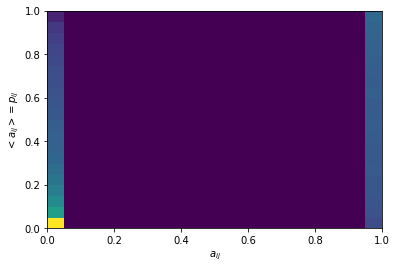

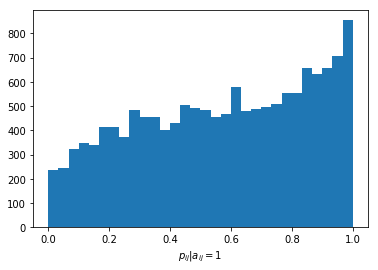

In [33]:
gamma=0.3
plt.hist2d(A.flatten(),pij.flatten(),bins=20,norm=mcolors.PowerNorm(gamma))
plt.xlabel("$a_{ij}$")
plt.ylabel("$<a_{ij}>=p_{ij}$")
plt.show()
idx_nnz = A.flatten()>0
plt.hist(pij.flatten()[idx_nnz],30 )
plt.xlabel('$p_{ij}|a_{ij}=1$')
plt.show()

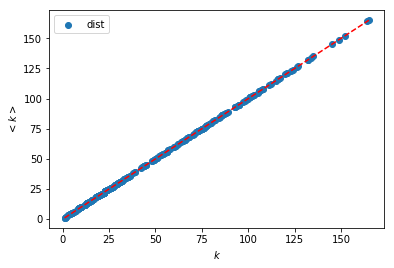

In [30]:
#plt.scatter(k,k_avg, label='no dist');
plt.scatter(k,k_avg_dist, label='dist');
plt.plot( [k.min(),k.max()],[k.min(),k.max()], 'r--')
plt.legend()
plt.xlabel('$k$')
plt.ylabel('$<k>$')
plt.show()

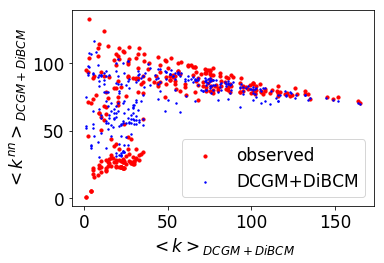

In [25]:
plt.scatter(k,knn_, c='r',s=10, label='observed' )
plt.scatter(k_avg_dist, knn_avg_dist, c='b',s=2, label='DCGM+DiBCM')
plt.xlabel('$<k>_{DCGM+DiBCM}$')
plt.ylabel('$< k^{nn} >_{DCGM+DiBCM}$')
plt.legend()
fig = plt.gcf()
fig.subplots_adjust(bottom=0.2,left=0.2)
#plt.show()
plt.savefig('knn_distUBCM.pdf')

/home/aurelien/local/git/cm_ml/cmtools.py:1213: RuntimeWarning: divide by zero encountered in double_scalars
  knn[i]= 1./k[i] * np.dot(P[i,:], mysum)
/home/aurelien/local/git/cm_ml/cmtools.py:1213: RuntimeWarning: invalid value encountered in double_scalars
  knn[i]= 1./k[i] * np.dot(P[i,:], mysum)


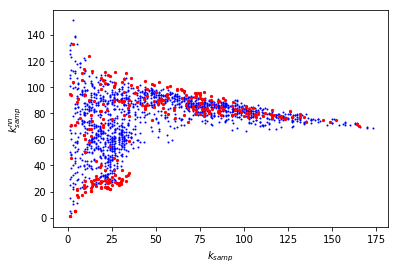

In [35]:
# samples
nsamp=10
n = pij.shape[0]
rnd = np.random.rand(n*n*nsamp).reshape((n,n,nsamp))
aij_sample=samples_UBCM(pij, rnd)

ki_sample = sample_k_UDCGM(aij_sample,nsamp, naive=False)
knn_sample = sample_knn_UDCGM(aij_sample,ki_sample,nsamp)
    
plt.scatter(ki_sample[:,0:5].flatten(),knn_sample[:,0:5].flatten(),c='b',s=1)
plt.scatter(k,knn_, c='r',s=5 )
    #plt.ylim([0,200])
plt.xlabel('$k_{samp}$')
plt.ylabel('$k^{nn}_{samp}$')
plt.show()

Distance-based indicators [Ruzzenenti et al .2012]. They're designed for **directed** networks but can be used in that case also.

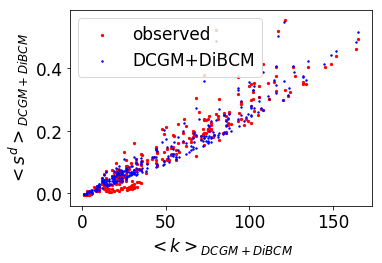

In [26]:
# local measure: $l_i$
l_i_in, l_i_out = l_i(A,D_) 
l_i_in_distUBCM, l_i_out_distUBCM = l_i(pij,D_) 
# plot
plt.scatter(k,l_i_in,c='r',s=5, label="observed");
plt.scatter(k_avg_dist,l_i_in_distUBCM,c='b',s=2,label='DCGM+DiBCM');
plt.xlabel('$< k >_{DCGM+DiBCM}$')
plt.ylabel('$< s^d >_{DCGM+DiBCM}$')
plt.legend()
fig = plt.gcf()
fig.subplots_adjust(bottom=0.2,left=0.2)
#plt.show()
plt.savefig('sd_distUBCM.pdf')

Comment:
    
   * should be compared to [DBCM](#DBCM) which distinguishes two components in the low-$k$ region. This hints to look at a **directed equivalent of distUBCM**.
    

Text(0, 0.5, '$A_i$')

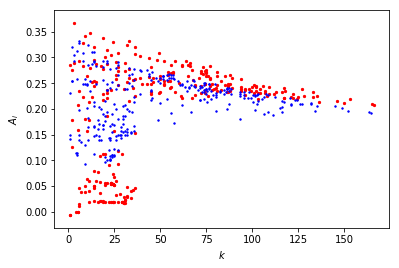

In [8]:
# local measure: assortativity    
A_in,A_out = assortativity(A,l_i_in,l_i_out,k_in=k,k_out=k)
A_in_distUBCM,A_out_distUBCM = assortativity(pij,l_i_in_distUBCM,l_i_out_distUBCM,
                            k_in=k_avg_dist,k_out=k_avg_dist)
# plot    
plt.scatter(k,A_in,c='r',s=5);
plt.scatter(k_avg_dist,A_in_distUBCM,c='b',s=2);
plt.xlabel('$k$')
plt.ylabel('$A_i$')


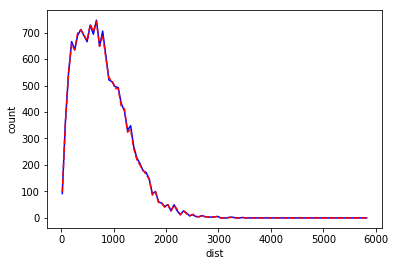

In [37]:
# histogram count(aij_sample)=f(dist), vs real data
# see [Kaluza et al. 10]
classes = np.sort(np.unique(class_dij))
#discard -1
classes = classes[classes>=0]
histbydij = hist_by_dij(class_dij,aij_sample,classes)
aij_3d = np.zeros((pij.shape[0],pij.shape[0],1))
#aij_3d[:,:,0]=pij;  histbydij_avg = hist_by_dij(class_dij,pij_3d,classes)
aij_3d[:,:,0]=A; histbydij_ = hist_by_dij(class_dij,aij_3d,classes)

plt.plot(bin_edges[:-1], histbydij/nsamp,'b')
#plt.plot(bin_edges[:-1], histbydij_avg,'r--')
plt.plot(bin_edges[:-1], histbydij_,'r--')
plt.xlabel('dist')
plt.ylabel('count')
plt.show()


Comment:
    
   * good fit (around 1% error).

# distUBCM +UDCGM

Fit distUBCM for the topology, and some other algorithm able to account for the weights (UDCGM, UECM two-step).

In [15]:
# UDCGM for weight structure
# undirected
g = d[tra_type]

A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)
k=np.array(A.sum(axis=0))
s = np.array(g.strength(weights="weight"))
W = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute='weight', default=0, eids=False)
W = np.array(W.data)
D_= D+D.transpose()

nbins=50
class_dij,B_d,bin_edges = get_classes(D_,A,bins=nbins)
dij=D; Nd=nbins
pij,z_,W_ = solve_lagrangian_distance(k,D_,class_dij,B_d,Nd,loops=1000,precision=10e-2)

In [16]:
# sample UDCGM
P=pij
wij_sample = sample_wij_UDCGM(P,s,nsamp=30,correction=True)
aij_sample = 1.*(wij_sample>0)
aij_avg = aij_avg_UDCGM(wij_sample)
wij_avg= wij_avg_UDCGM(wij_sample)
k_avg = np.sum(aij_avg,axis=0)	
s_avg = np.sum(wij_avg,axis=0)
snn_avg = snn(P,k_avg,s_avg)

# knn
knn_avg = knn_avg_UBCM(P,k_avg)
knn_sigma = knn_sigma_sample(aij_sample,directed=False)
# snn
snn_ = snn(A,k,s)
snn_sigma = snn_sigma_sample(wij_sample,directed=False)

/home/aurelien/local/git/cm_ml/cmtools.py:432: RuntimeWarning: divide by zero encountered in true_divide
  Wij = (Wij+Wij_correc)/P
/home/aurelien/local/git/cm_ml/cmtools.py:1324: RuntimeWarning: divide by zero encountered in true_divide
  snn = snn/k
/home/aurelien/local/git/cm_ml/cmtools.py:1324: RuntimeWarning: invalid value encountered in true_divide
  snn = snn/k


/home/aurelien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


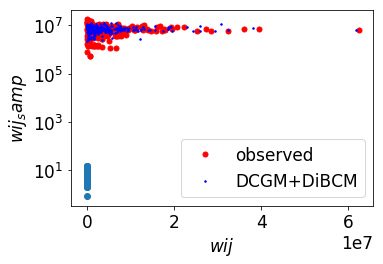

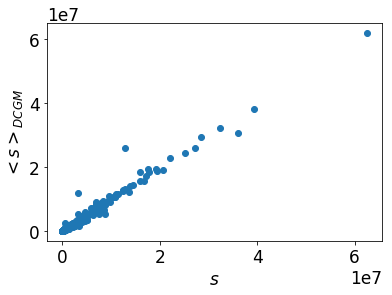

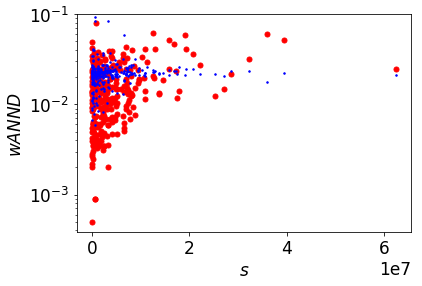

In [19]:

#plt.semilogy(s,snn_  , 'ro',markersize=10 ) 
log = True#False
if log:
    plt.semilogy(s,snn_  , 'ro',markersize=5,label="observed" ) 
    plt.semilogy(s_avg, snn_avg , 'b.',markersize=3,label="DCGM+DiBCM" ) 
    #plt.semilogy(s_avg, snn_avg+snn_sigma, 'g.',markersize=2 ) 
    #plt.semilogy(s_avg,snn_avg-snn_sigma , 'g.',markersize=2 ) 
else:
    plt.scatter(s,snn_  , c='r',s=5,label="observed") 
    plt.scatter(s_avg, snn_avg , c='b',s=10,label="DCGM+DiBCM" ) 
    #plt.scatter(s_avg, snn_avg+snn_sigma, c="g", s=2 ) #'g.',
    #plt.scatter(s_avg,snn_avg-snn_sigma , c='g',s=2 ) 
plt.xlabel('$<s>_{DCGM+DiBCM}$')
plt.ylabel('$< s^{nn} >_{DCGM+DiBCM}$')
plt.legend()
#plt.xlim([-1,600])
#plt.ylim([35,60])
fig = plt.gcf()
fig.subplots_adjust(bottom=0.2,left=0.2)
#plt.show()
plt.savefig('snn_DCGM+distUBCM.pdf')

#plt.scatter(W.flatten(), wij_sample[:,:,0].flatten() )
plt.scatter( np.log(W.flatten()), np.log(wij_sample[:,:,0].flatten()) )
plt.xlabel('$wij$')
plt.ylabel('$wij_samp$')
#plt.xlim([0,1.0e7]); plt.ylim([0,1.0e7])
plt.show()

plt.scatter(s,s_avg)
plt.xlabel('$s$')
plt.ylabel('$<s>_{DCGM}$')
plt.show()

wknn_ = wknn(W,s)
wknn_theor = wknn(wij_avg,s)
wknn_sigma = wknn_sigma_sample(wij_sample,directed=False)    

#plt.scatter(s,wknn_,c='r',s=10)

#plt.scatter(s,wknn_,c='r',s=10)
#plt.scatter(s,wknn_theor,c='b',s=2)
plt.semilogy(s,wknn_,'ro',markersize=5)
plt.semilogy(s,wknn_theor,'b.',markersize=3)

#plt.scatter(s, wknn_theor+wknn_sigma,c='g',s=2)
#plt.scatter(s, wknn_theor-wknn_sigma,c='g',s=2)
plt.xlabel("$s$")
plt.ylabel("$wANND$")
plt.ylim([0,0.1])

plt.show()

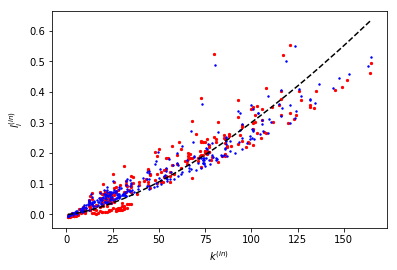

In [96]:
# local measure: $l_i$
l_i_in, l_i_out = l_i(A,D_) 
l_i_in_UDCGM, l_i_out_UDCGM = l_i(pij,D_) 
# plot
kin=k
plt.scatter(kin,l_i_in,c='r',s=5);
plt.scatter(k_avg,l_i_in_UDCGM,c='b',s=2);
# TODO: FIT alpha value
alpha=0.0003
plt.plot(np.sort(k_avg),alpha*np.sort(k_avg)**(3/2), 'k--')# popovic
plt.xlabel('$k^{(in)}$')
plt.ylabel('$l_i^{(in)}$')
plt.show()

plt.show()

Text(0, 0.5, '$A_i$')

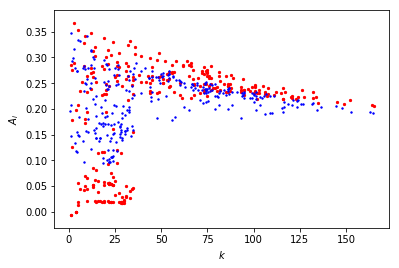

In [97]:
# local measure: assortativity    
A_in_UDCGM,A_out_UDCGM = assortativity(pij,l_i_in_UDCGM,l_i_out_UDCGM,
                            k_in=k_avg,k_out=k_avg)

A_in,A_out = assortativity(A,l_i_in,l_i_out,k_in=k,k_out=k)
                        
# plot    
plt.scatter(k,A_in,c='r',s=5);
plt.scatter(k_avg,A_in_UDCGM,c='b',s=2);
#plt.ylim([0,1])
plt.xlabel('$k$')
plt.ylabel('$A_i$')

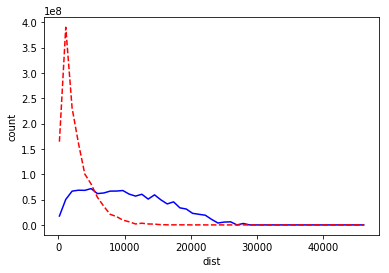

In [65]:
# histogram count(wij_sample)=f(dist), vs real data
# see [Kaluza et al. 10]
classes = np.sort(np.unique(class_dij))
#discard -1
classes = classes[classes>=0]
#histbydij = hist_by_dij(class_dij,wij_sample,classes)
wij_3d = np.zeros((W.shape[0],W.shape[0],1))
wij_3d[:,:,0]=W; histbydij_ = hist_by_dij(class_dij,wij_3d,classes)

wij_avg_3d = np.zeros((W.shape[0],W.shape[0],1))
wij_avg_3d[:,:,0]=wij_avg;
histbydij = hist_by_dij(class_dij,wij_avg_3d,classes)

plt.plot(bin_edges[:-1], histbydij,'b')
#plt.plot(bin_edges[:-1], histbydij_avg,'r--')
plt.plot(bin_edges[:-1], histbydij_,'r--')
plt.xlabel('dist')
plt.ylabel('count')
plt.show()

Comment:
    
   * poor fit. Because with this model, $<w_{ij}>$ is fit correctly, but not $w_{ij}$

Samples:

Commentaires:
    
    * wANND pas bon fit.

## distUBCM+UECM

In [3]:
# two-step UECM for weights
#
# undirected
g = d[tra_type]

A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)
W = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute='weight', default=0, eids=False)
W = np.array(W.data)    
k=np.array(A.sum(axis=0))
D_= D+D.transpose()

nbins=50
class_dij,B_d,bin_edges = get_classes(D_,A,bins=nbins)
dij=D; Nd=nbins
pij,z,Wd = solve_lagrangian_distance(k,D_,class_dij,B_d,Nd,loops=1000,precision=10e-2)
k_avg_dist = np.sum(pij,axis=0)

knn_avg_dist = knn_avg_UBCM(pij,k_avg_dist) 
knn_ = knn_avg_UBCM(A,k) 

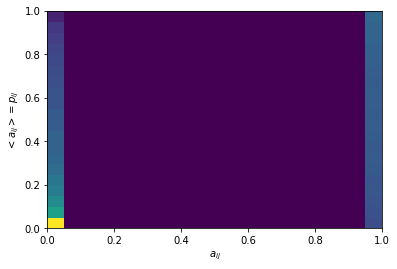

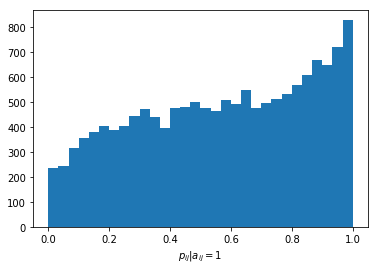

In [9]:
gamma=0.3
plt.hist2d(A.flatten(),pij.flatten(),bins=20,norm=mcolors.PowerNorm(gamma))
plt.xlabel("$a_{ij}$")
plt.ylabel("$<a_{ij}>=p_{ij}$")
plt.show()
idx_nnz = A.flatten()>0
plt.hist(pij.flatten()[idx_nnz],30 )
plt.xlabel('$p_{ij}|a_{ij}=1$')
plt.show()

In [6]:
np.min(W),np.max(W)
W_resc = W*1e-5; precision = 1e-2
#W_resc = np.log(W+1);  precision = 1e-2 # LOG-TRANSFORM !!!!!!!!!
s_resc = np.sum(W_resc,axis=0)
y,max_, success = solve_iter_UECM_two_step_wij(pij,s_resc,loops=1000,precision=precision)
print(y)
#y,success=solve_root_UECM_two_step_wij(pij,s_resc,y0=y,method='hybr',jac=None)
#y,success = solve_opt_UECM_two_step_wij(pij,s_resc,method='BFGS',y0=None,jac=None)
if not success: warnings.warn('solve_UECM_two_step_wij did not converge')
wij_avg=wij_avg_from_pij_y(pij,y)
#yy = np.outer(y,y)
#np.fill_diagonal(yy,0)
#wij_avg = pij/(1.-yy)
wij_avg = np.clip(wij_avg, 0,W_resc.max())

[[2.03393966e-01]
 [3.22758411e-01]
 [3.52848706e+00]
 [2.60549434e-02]
 [4.88695701e-01]
 [2.85830246e-01]
 [1.37760331e-01]
 [7.35579448e-02]
 [5.52290251e-01]
 [2.56687702e-01]
 [4.12280455e-01]
 [1.03172063e-01]
 [1.46675063e-01]
 [1.99988703e+00]
 [3.47484211e+00]
 [2.33513663e+00]
 [1.02641644e+00]
 [9.61432925e-02]
 [7.93958366e-01]
 [2.55945318e-01]
 [2.35185213e-01]
 [2.50841093e+00]
 [1.02209498e+00]
 [3.21545696e-01]
 [4.23290351e-02]
 [5.09560037e-01]
 [7.60196278e-02]
 [4.37592964e-01]
 [1.73043212e+00]
 [2.78962472e-01]
 [1.48238891e-01]
 [1.23804642e+00]
 [2.72462801e-01]
 [5.96655286e-01]
 [1.96550308e-01]
 [2.84292588e-01]
 [1.88806441e+00]
 [5.12599269e-02]
 [8.32667442e-02]
 [1.62256751e-01]
 [6.61158000e-01]
 [1.00000000e-14]
 [1.51967281e+01]
 [5.04190337e-01]
 [1.22602605e+00]
 [5.65650256e-01]
 [5.48024224e-01]
 [7.25808134e-02]
 [1.94850104e-01]
 [1.40939964e-01]
 [1.00000000e-14]
 [7.31245699e-01]
 [1.67571136e-01]
 [7.27666076e-02]
 [4.18909566e-01]
 [4.177460

/home/aurelien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: solve_UECM_two_step_wij did not converge
  if __name__ == '__main__':


In [7]:
# regress s, s_avg
slope, intercept, r_value, p_value, std_err = stats.linregress(s_resc,np.sum(wij_avg,axis=0))
print(slope)
#slope=1

0.6246270498893646


In [8]:
k_avg = np.sum(pij,axis=0)	
s_avg = np.sum(wij_avg,axis=0)
snn_avg = snn(pij,k_avg, s_avg)
snn_ = snn(pij,k,s_resc)

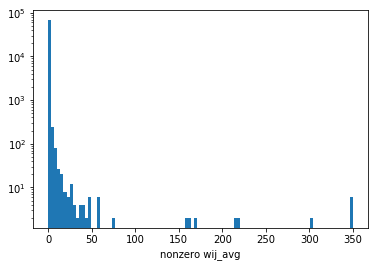

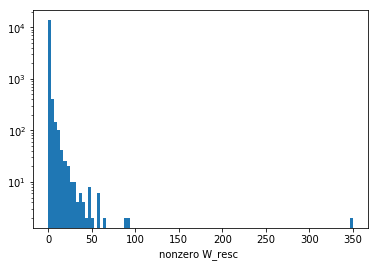

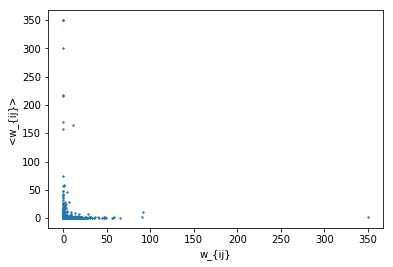

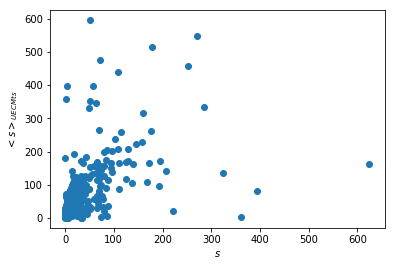

In [9]:
plt.hist(wij_avg.flatten()[wij_avg.flatten()>0],100,log=True)
plt.xlabel('nonzero wij_avg')
plt.show()
plt.hist(W_resc.flatten()[W_resc.flatten()>0],100,log=True)
plt.xlabel('nonzero W_resc ')
plt.show()
#plt.scatter( np.log(W_resc.flatten() ), np.log(wij_avg.flatten()) ) ; 
plt.scatter( W_resc.flatten() , wij_avg.flatten(),s=1 ) ; 
plt.xlabel('w_{ij}')
plt.ylabel('<w_{ij}>')
#plt.xlim([0,100]); plt.ylim([0,2.5])
plt.show()
#plt.scatter(np.log(s_resc),np.log(s_avg))
plt.scatter(s_resc,s_avg)
plt.xlabel('$s$')
plt.ylabel('$<s>_{UECMts}$')
#plt.xlim([0,100]); plt.ylim([0,100])
plt.show()

Comment:

   * problème avec $p_{ij}$

(0, 200)

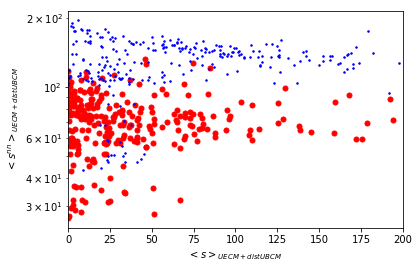

In [12]:
#plt.scatter(s_resc,snn_  , c='r',s=5) 
#a=0.62; plt.scatter(a*s_avg, a*snn_avg , c='b',s=10 ) 
plt.semilogy(s_resc,snn_  , 'ro',markersize=5 ) 
plt.semilogy(s_avg, snn_avg , 'b.',markersize=3 ) 

plt.xlabel('$<s>_{UECM+distUBCM}$')
plt.ylabel('$<s^{nn} >_{UECM+distUBCM}$')
plt.xlim([0,200])

Commentaires:
    
   * UDCGM good fit for weight structure: $s$ ok, $s^{nn}$ ok, wknn: offset (?).
      *  ! two values only for $w_{ij}^{sample}$, as usual with UDCGM.
   * UECM two-step: 


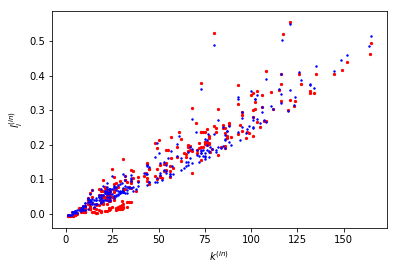

In [33]:
# local measure: $l_i$
l_i_in, l_i_out = l_i(A,D_) 
l_i_in_DBCM, l_i_out_DBCM = l_i(pij,D_) 
# plot
kin=k
plt.scatter(kin,l_i_in,c='r',s=5);
plt.scatter(k_avg,l_i_in_DBCM,c='b',s=2);
plt.xlabel('$k^{(in)}$')
plt.ylabel('$l_i^{(in)}$')
plt.show()
#plt.scatter(kout,l_i_out,c='r',s=5);
#plt.scatter(kout_DBCM,l_i_out_DBCM,c='b',s=2);
#plt.xlabel('$k^{(out)}$')
#plt.ylabel('$l_i^{(out)}$')

plt.show()

Comment: 
    
   * low k zone ???? 

# FiUGM Fitness Induced Undirected Gravity Model

[Squartini et al. 14] see eq(9.18)

$p_{ij}=\frac{z GDP_i GDP_j \exp{-\gamma d_{ij}}}{1+ z GDP_i GDP_j \exp{-\gamma d_{ij}}}$


$d_{ij}$ is used here.


In [13]:
# undirected
g = d[tra_type]

A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)
k=np.array(A.sum(axis=0))
D_= D+D.transpose()


sol = solve_FiUGM(k,D_,method="Nelder-Mead",x0=[0.1,1.])
u,v = sol.x[0],sol.x[1]
pij = pij_FiUGM(k,D_,u,v)
assert not np.any(pij>=1)
assert not np.any(pij<0)

k_avg = k_avg_UBCM(pij)
knn_ = knn_avg_UBCM(A,k) 
knn_avg = knn_avg_UBCM(pij,k_avg) 

print(sol)


/home/aurelien/.local/lib/python3.5/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


 final_simplex: (array([[0.19094417, 0.00866193],
       [0.19103447, 0.00866258],
       [0.19090326, 0.00866164]]), array([2.37836521e-08, 2.82477833e-06, 3.49054656e-06]))
           fun: 2.3783652081989118e-08
       message: 'Optimization terminated successfully.'
          nfev: 103
           nit: 55
        status: 0
       success: True
             x: array([0.19094417, 0.00866193])


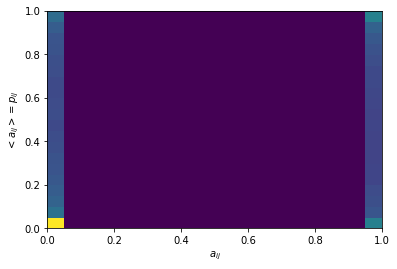

Text(0.5, 0, '$p_{ij}|a_{ij}=1$')

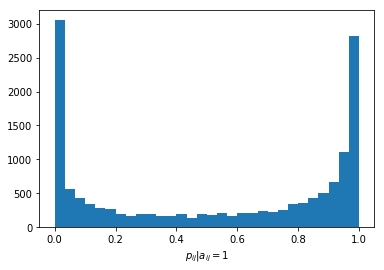

In [14]:
gamma=0.3
plt.hist2d(A.flatten(),pij.flatten(),bins=20,norm=mcolors.PowerNorm(gamma))
plt.xlabel("$a_{ij}$")
plt.ylabel("$<a_{ij}>=p_{ij}$")
plt.show()
idx_nnz = A.flatten()>0
plt.hist(pij.flatten()[idx_nnz],30 )
plt.xlabel('$p_{ij}|a_{ij}=1$')

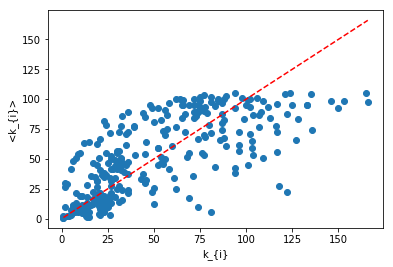

In [11]:
plt.scatter(k,k_avg);
plt.xlabel('k_{i}')
plt.ylabel('<k_{i}>')
m,M=np.min(k),np.max(k)
plt.plot([m,M],[m,M],'r--')
plt.show()

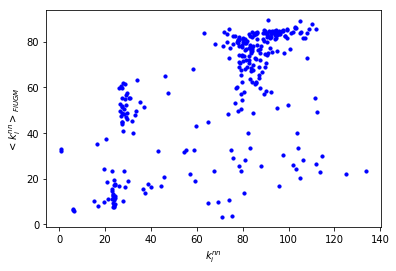

In [12]:
plt.scatter(knn_,knn_avg, c='b',s=10 )
plt.xlabel('$k^{nn}_{i}$')
plt.ylabel('$<k^{nn}_{i}>_{FiUGM}$')
plt.show()


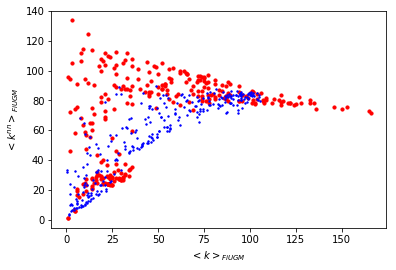

In [13]:
plt.scatter(k,knn_, c='r',s=10 )
plt.scatter(k_avg, knn_avg, c='b',s=2)
plt.xlabel('$<k>_{FiUGM}$')
plt.ylabel('$< k^{nn} >_{FiUGM}$')
#plt.ylim([0,200])
plt.show()

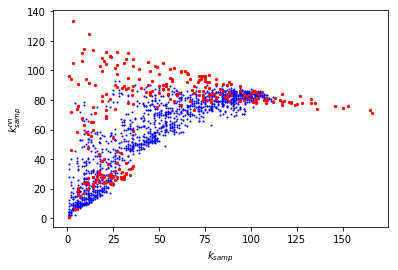

In [15]:
# samples
nsamp=10
n = pij.shape[0]
rnd = np.random.rand(n*n*nsamp).reshape((n,n,nsamp))
aij_sample=samples_UBCM(pij, rnd)

ki_sample = sample_k_UDCGM(aij_sample,nsamp, naive=False)
knn_sample = sample_knn_UDCGM(aij_sample,ki_sample,nsamp)
    
plt.scatter(ki_sample[:,0:5].flatten(),knn_sample[:,0:5].flatten(),c='b',s=1)
plt.scatter(k,knn_, c='r',s=5 )
    #plt.ylim([0,200])
plt.xlabel('$k_{samp}$')
plt.ylabel('$k^{nn}_{samp}$')
plt.show()

Commentaires:
    
   * le seul dont $< k^{nn}>_{model}$ n'est pas continu en $k$ et fait apparaître le groupe low $k$/low $k^{nn}$
   * TODO: sample, sigma, ...
    

$d_{ij}$ is replaced by impedance below.

In [16]:
# undirected
g = d[tra_type]
# remove node
seq = g.vs.select(name_eq=1230000) 
if len(seq)>0:
    idx = seq[0].index
    g.delete_vertices(idx)
#else: raise ValueError()    
# 
A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)
W = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute='weight', default=0, eids=False)
W = np.array(W.data)
s = np.array(g.strength(weights="weight"))
k=np.array(A.sum(axis=0))

# get distance
imp=read_group_impedance_EZ2006_2()
# get node names
#d_etis = load_etisplus(year='2010',geodata=True, data_src='observed', directed=False)
#tra_type='rail'
# match name and imp
name = g.vs['name']
D_imp = get_impedance_matrix(name,imp) 


sol = solve_FiUGM(k,D_imp,method="Nelder-Mead",x0=[0.1,1.])
u,v = sol.x[0],sol.x[1]
pij = pij_FiUGM(k,D_imp,u,v)
assert not np.any(pij>=1)
assert not np.any(pij<0)

k_avg = k_avg_UBCM(pij)
knn_ = knn_avg_UBCM(A,k) 
knn_avg = knn_avg_UBCM(pij,k_avg) 

print(sol)

/home/aurelien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: multiple edge
  del sys.path[0]


 final_simplex: (array([[0.18736395, 0.01052771],
       [0.18731252, 0.01052725],
       [0.18739979, 0.01052804]]), array([8.98552228e-06, 2.79651765e-05, 1.06066354e-04]))
           fun: 8.985522284002731e-06
       message: 'Optimization terminated successfully.'
          nfev: 98
           nit: 52
        status: 0
       success: True
             x: array([0.18736395, 0.01052771])


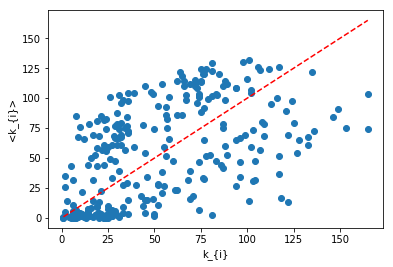

In [17]:
plt.scatter(k,k_avg);
plt.xlabel('k_{i}')
plt.ylabel('<k_{i}>')
m,M=np.min(k),np.max(k)
plt.plot([m,M],[m,M],'r--')
plt.show()

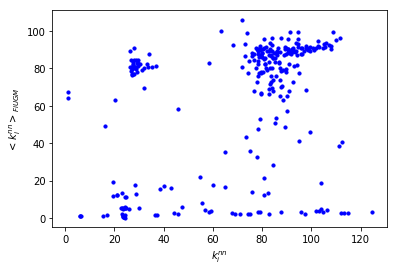

In [18]:
plt.scatter(knn_,knn_avg, c='b',s=10 )
plt.xlabel('$k^{nn}_{i}$')
plt.ylabel('$<k^{nn}_{i}>_{FiUGM}$')
plt.show()

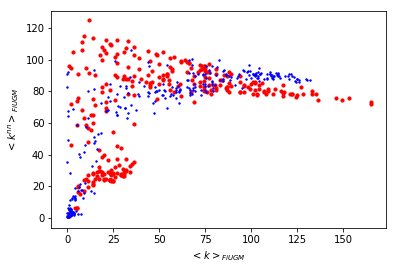

In [19]:
plt.scatter(k,knn_, c='r',s=10 )
plt.scatter(k_avg, knn_avg, c='b',s=2)
plt.xlabel('$<k>_{FiUGM}$')
plt.ylabel('$< k^{nn} >_{FiUGM}$')
#plt.ylim([0,200])
plt.show()

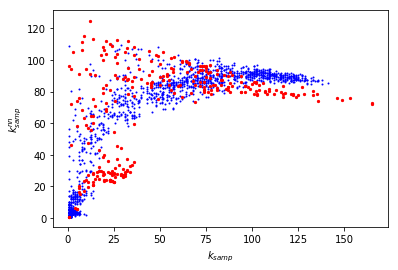

In [20]:
# samples
nsamp=10
n = pij.shape[0]
rnd = np.random.rand(n*n*nsamp).reshape((n,n,nsamp))
aij_sample=samples_UBCM(pij, rnd)

ki_sample = sample_k_UDCGM(aij_sample,nsamp, naive=False)
knn_sample = sample_knn_UDCGM(aij_sample,ki_sample,nsamp)
    
plt.scatter(ki_sample[:,0:5].flatten(),knn_sample[:,0:5].flatten(),c='b',s=1)
plt.scatter(k,knn_, c='r',s=5 )
    #plt.ylim([0,200])
plt.xlabel('$k_{samp}$')
plt.ylabel('$k^{nn}_{samp}$')
plt.show()

With $f=\frac{1}{x^\alpha}$

In [9]:
# undirected
g = d[tra_type]

A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)
k=np.array(A.sum(axis=0))
D_= D+D.transpose()

sol = solve_FiUGM(k,D_,method="Nelder-Mead",x0=[0.1,1.],fun='pow')
u,v = sol.x[0],sol.x[1]
pij = pij_FiUGM(k,D_,u,v,fun='pow')
assert not np.any(pij>=1)
assert not np.any(pij<0)

k_avg = k_avg_UBCM(pij)
knn_ = knn_avg_UBCM(A,k) 
knn_avg = knn_avg_UBCM(pij,k_avg) 

print(sol)

/home/aurelien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: multiple edge
  import sys
/home/aurelien/.local/lib/python3.5/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


ValueError: v must be >0

With data-driven $f$:

Commentaire:
    
   * f


# UECM

Two-step version [Almog et al. 15] arxiv: 1512.02454

In [27]:
# load
g = d[tra_type]
A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)

W = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute='weight', default=0, eids=False)
W = np.array(W.data)
s = np.array(g.strength(weights="weight"))
k=np.array( A.sum(axis=0))

# fit the degree in the two-step model
pij_ts,wij_avg = solve_UECM_two_step(k,s,loops=1000,precision=10e-3)


/home/aurelien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: multiple edge
  


/home/aurelien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


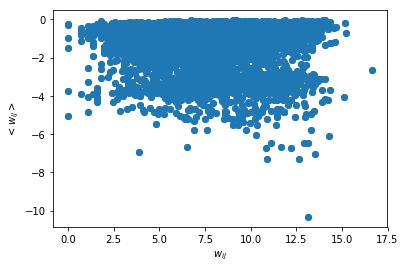

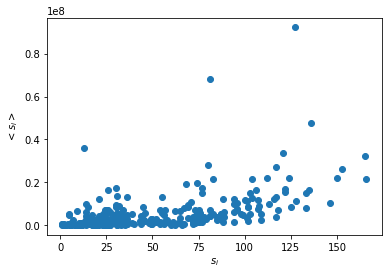

In [29]:
plt.scatter(np.log(W.flatten()),np.log(wij_avg.flatten()) ); 
plt.xlabel("$w_{ij}$")
plt.ylabel("$<w_{ij}>$")
plt.show()
plt.scatter(np.sum(wij_avg,axis=0),s )
plt.xlabel("$s_{i}$")
plt.ylabel("$<s_{i}>$")

plt.show()

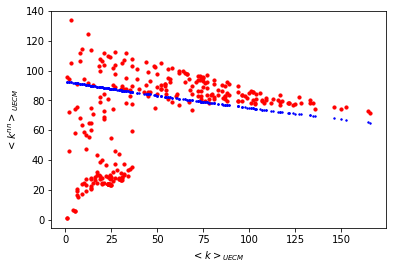

In [30]:
knn_ = knn_avg_UBCM(A,k)

k_avg = np.sum(pij_ts,axis=0)
knn_avg = knn_avg_UBCM(pij_ts,k_avg) 

plt.scatter(k,knn_, c='r',s=10 )
plt.scatter(k_avg, knn_avg, c='b',s=2)
plt.xlabel('$<k>_{UECM}$')
plt.ylabel('$< k^{nn} >_{UECM}$')
plt.show()

In [33]:
# regress s, s_avg
slope, intercept, r_value, p_value, std_err = stats.linregress(s,np.sum(wij_avg,axis=0))

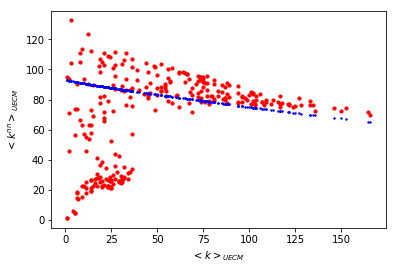

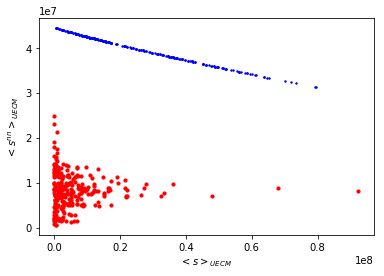

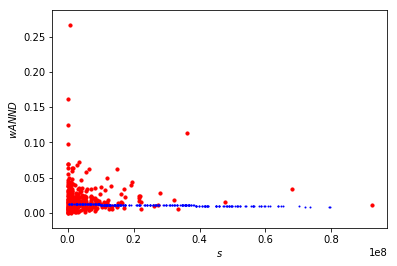

In [37]:
knn_ = knn_avg_UBCM(A,k)
snn_ = snn(A,k,s)
wknn_ = wknn(W,s)

k_avg = np.sum(pij_ts,axis=0)
s_avg = np.sum(wij_avg,axis=0)
wknn_avg = wknn(wij_avg,s_avg/slope)

knn_avg = knn_avg_UBCM(pij_ts,k_avg) 
snn_avg = snn(pij_ts,k_avg, s_avg/slope)

plt.scatter(k,knn_, c='r',s=10 )
plt.scatter(k_avg, knn_avg, c='b',s=2)
plt.xlabel('$<k>_{UECM}$')
plt.ylabel('$<k^{nn} >_{UECM}$')
plt.show()

plt.scatter(s, snn_ , c='r',s=10 )
plt.scatter(s_avg/slope, snn_avg, c='b',s=2)
plt.xlabel('$<s>_{UECM}$')
plt.ylabel('$<s^{nn} >_{UECM}$')
plt.show()

plt.scatter(s,wknn_,c='r',s=10)
plt.scatter(s_avg/slope,wknn_avg,c='b',s=1)
plt.xlabel("$s$")
plt.ylabel("$wANND$")
plt.show()

In [ ]:
TODO : UECM two step avec pij_dist

# UEGM

cf [Mastrandrea et al 14]

In [20]:
# undirected
g = d[tra_type]
A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)
W = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute='weight', default=0, eids=False)
W = np.array(W.data)
s = np.array(g.strength(weights="weight"))
k=np.array(A.sum(axis=0))
D_= D+D.transpose()
np.fill_diagonal(D_,1.0)

# 
factor = 0.5e-6
W = factor* W
s = np.sum(W,axis=0)
L=np.sum(k)

maxiter = 10000
z0=[1,0.1,0.1]
sol_F,sol_G=solve_UEGM(W,A,s,D_,L,z0=z0,method='hybr',jac=None,
							options={'maxiter':maxiter,'maxfev':10000,'ftol':1e-2},
							fun=eq_UEGM_GDP)
print(sol_F)
print(sol_G)
assert sol_F.success
assert sol_G.success

delta= sol_G.x[0]
c    = sol_F.x[0]    
alpha= sol_F.x[1]    
gamma= sol_F.x[2]    							
xij,yij=x_y_UEGM_GDP(s, delta,c,alpha,gamma,D_)	
pij = pij_UEGM(xij,yij)						
assert not np.any(pij>=1)
assert not np.any(pij<0)

    fjac: array([[-0.12150531, -0.70216304, -0.70157218],
       [ 0.97709387, -0.20902072,  0.03997383],
       [ 0.17471127,  0.68064484, -0.71147633]])
     fun: array([-1.03986677e-08, -7.72339559e-09, -7.83382603e-09])
 message: 'The solution converged.'
    nfev: 25
     qtf: array([2.72569543e-07, 2.48176411e-07, 4.49182571e-08])
       r: array([ 6.85140537e+05,  3.97384253e+06, -3.98416593e+06, -1.34866698e+04,
        1.33528244e+04,  2.44787787e+03])
  status: 1
 success: True
       x: array([1.01697875, 0.79244524, 0.7943976 ])
    fjac: array([[-1.]])
     fun: 1.1823431123048067e-10
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-4.74938133e-09])
       r: array([-86232.4527874])
  status: 1
 success: True
       x: array([0.09369355])


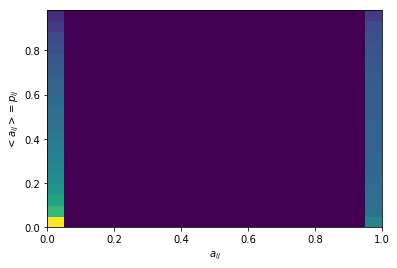

Text(0.5, 0, '$p_{ij}|a_{ij}=1$')

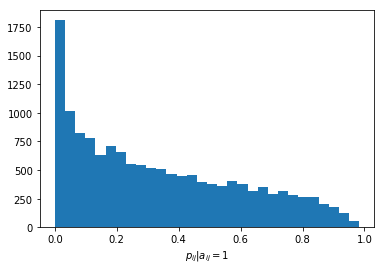

In [4]:
gamma=0.3
plt.hist2d(A.flatten(),pij.flatten(),bins=20,norm=mcolors.PowerNorm(gamma))
plt.xlabel("$a_{ij}$")
plt.ylabel("$<a_{ij}>=p_{ij}$")
plt.show()
idx_nnz = A.flatten()>0
plt.hist(pij.flatten()[idx_nnz],30 )
plt.xlabel('$p_{ij}|a_{ij}=1$')

In [21]:
k_avg = np.sum(pij,axis=0)
wij_avg = wij_avg_UEGM(pij,yij)
s_avg = np.sum(wij_avg,axis=0)

#k_avg = k_avg_UBCM(pij)
knn_avg = knn_avg_UBCM(pij,k_avg) 
knn_ = knn_avg_UBCM(A,k)
snn_avg = snn(pij,k_avg,s_avg)

# weighted ANND
wknn_ = wknn(W,s)
wknn_avg = wknn(wij_avg,s_avg)


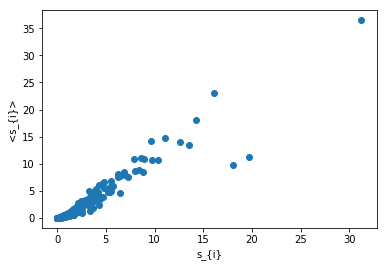

In [98]:
plt.scatter(s,s_avg);
plt.xlabel('s_{i}')
plt.ylabel('<s_{i}>')
plt.show()

In [ ]:
# TODO: bias_s = f(spatial eccentricity)

Commentaire:
    
   * fit $k$ ? 
   * fit $s$ ok
   * f(spatial eccentricity) ???
    

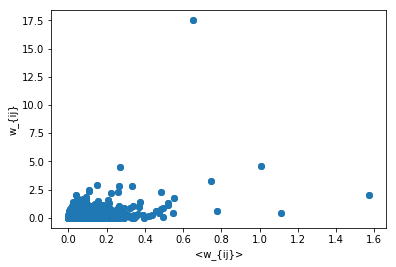

In [10]:
plt.scatter( wij_avg, W.flatten()); 
#plt.scatter( np.log(wij_avg), np.log(W.flatten() )) ; 
plt.xlabel('<w_{ij}>')
plt.ylabel('w_{ij}')
#plt.xlim([0,0.2]); plt.ylim([0,2])
plt.show()

In [6]:
# regress s, s_avg
slope, intercept, r_value, p_value, std_err = stats.linregress(W.flatten(),wij_avg.flatten())
print(slope)
#slope=1

0.15126134558440724


Commentaire:
    
   * en échelle linéaire: fit pas bon sur les $w_{ij}$
   * en échelle log-log: proche de [Almog et al. 15]

In [69]:
# get ki sample, knn sample
n=k_avg.shape[0]
nsamp=10
wij_sample=np.zeros((n,n,nsamp),dtype=np.long)
cm_cy.samples_UWCM( pij, wij_sample)
# 
# RESCALE
wij_sample = slope*wij_sample

In [70]:
aij_sample = 1.*(wij_sample>0)
ki_sample= sample_k_UDCGM(aij_sample,nsamp, naive=False)
knn_sample = sample_knn_UDCGM(aij_sample,ki_sample,nsamp)
si_sample= sample_s(wij_sample,nsamp, naive=False)
wknn_sample = sample_wknn(wij_sample,si_sample,nsamp)


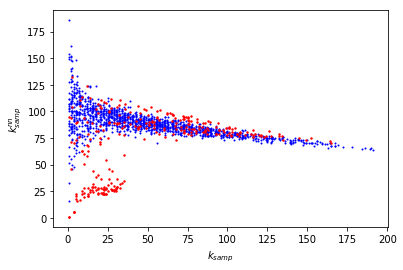

In [45]:
# k sample vs knn sample
plt.scatter(ki_sample[:,0:5].flatten(),knn_sample[:,0:5].flatten(),c='b',s=1)
plt.scatter(k,knn_, c='r',s=2 )
plt.xlabel('$k_{samp}$')
plt.ylabel('$k^{nn}_{samp}$')
#plt.ylim([0,200])
plt.show()

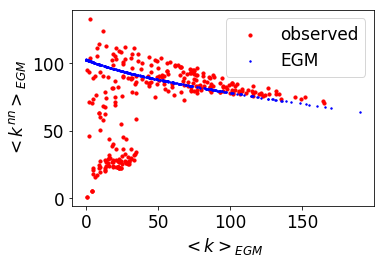

In [8]:
#knn_ = g_.knn()[0]
plt.scatter(k,knn_ , c='r',s=10,label='observed' )
plt.scatter(k_avg, knn_avg, c='b',s=2,label='EGM')
plt.xlabel('$<k>_{EGM}$')
plt.ylabel('$< k^{nn} >_{EGM}$')
plt.legend()
#plt.show()
fig = plt.gcf()
fig.subplots_adjust(bottom=0.2,left=0.2)
plt.savefig('knn_EGM.pdf')

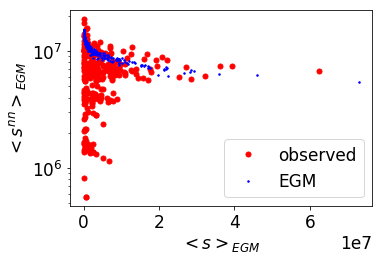

In [9]:
# rescaled
factor_=factor
log = True#False
if log:
    plt.semilogy(1/factor_*s , 1/factor_*snn(A,k,s) , 'ro',markersize=5,label="observed" ) 
    plt.semilogy(1/factor_*s_avg, 1/factor_*snn_avg , 'b.',markersize=3,label="EGM" ) 
else:
    plt.scatter(1/factor_*s, 1/factor_*snn(A,k,s) , c='r',s=10 ,label='observed')
    plt.scatter(1/factor_*s_avg, 1/factor_*snn_avg, c='b',s=2,label='EGM')
plt.xlabel('$<s>_{EGM}$')
plt.ylabel('$< s^{nn} >_{EGM}$')
plt.legend()
fig = plt.gcf()
fig.subplots_adjust(bottom=0.2,left=0.2)
#plt.show()
plt.savefig('snn_EGM.pdf')

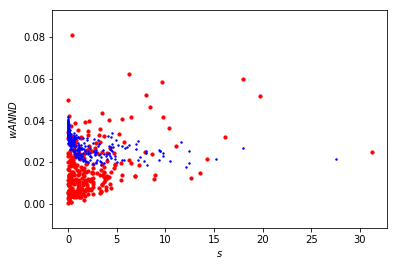

In [48]:
#plot nearest-neighbour 
plt.scatter(s,wknn_,c='r',s=10)
plt.scatter(s_avg,wknn_avg,c='b', s=2)
    
plt.xlabel("$s$")
plt.ylabel("$wANND$")
plt.show()

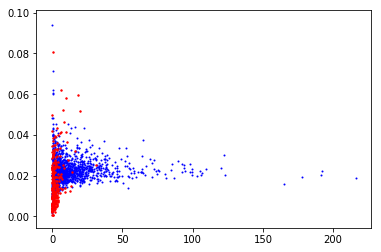

In [49]:
#plot wknn_sample
plt.scatter(si_sample[:,0:5].flatten(),wknn_sample[:,0:5].flatten(),c='b',s=1)
plt.scatter(s,wknn_, c='r',s=2 )
#plt.ylim([0,200])
plt.show()

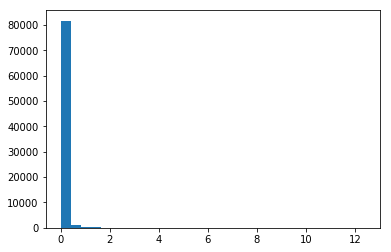

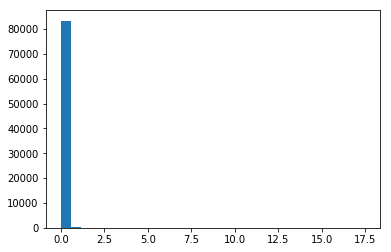

In [50]:
#TODO: sigma
#print(wij_sample.shape)
plt.hist(wij_sample[:,:,0].flatten(),30);plt.show()
plt.hist(W.flatten(),30);plt.show()


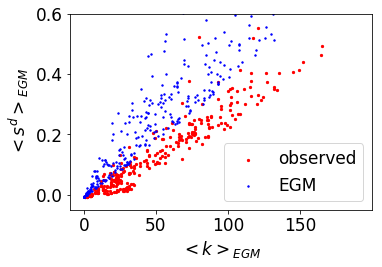

In [23]:
# local measure: $l_i$
l_i_in, l_i_out = l_i(A,D_) 
l_i_in_UEGM, l_i_out_UEGM = l_i(pij,D_) 
# plot
kin=k
plt.scatter(kin,l_i_in,c='r',s=5,label='observed');
plt.scatter(k_avg,l_i_in_UEGM,c='b',s=2,label='EGM');
plt.xlabel('$<k>_{EGM}$')#plt.xlabel('$k^{(in)}$')
plt.ylabel('$<s^d>_{EGM}$')
plt.legend()
#plt.show()
#plt.scatter(kout,l_i_out,c='r',s=5);
#plt.scatter(kout_DBCM,l_i_out_DBCM,c='b',s=2);
#plt.xlabel('$k^{(out)}$')
#plt.ylabel('$l_i^{(out)}$')
#plt.show()
plt.ylim([-0.05,0.6])
fig = plt.gcf()
fig.subplots_adjust(bottom=0.2,left=0.2)
plt.savefig('sd_EGM.pdf')

Text(0, 0.5, '$A_i$')

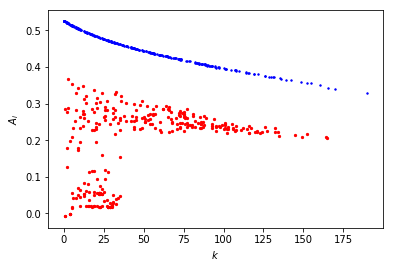

In [83]:
# local measure: assortativity    
A_in_UEGM,A_out_UEGM = assortativity(pij,l_i_in_UEGM,l_i_out_UEGM,
                            k_in=k_avg,k_out=k_avg)

A_in,A_out = assortativity(A,l_i_in,l_i_out,k_in=k,k_out=k)
                        
# plot    
plt.scatter(k,A_in,c='r',s=5);
plt.scatter(k_avg,A_in_UEGM,c='b',s=2);
#plt.ylim([0,1])
plt.xlabel('$k$')
plt.ylabel('$A_i$')

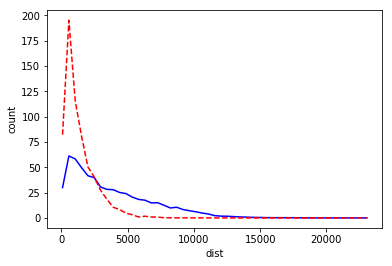

In [54]:
# histogram count(wij_sample)=f(dist), vs real data
# see [Kaluza et al. 10]
nbins=50
D_= D+D.transpose()
class_dij,B_d,bin_edges = get_classes(D_,A,bins=nbins)

classes = np.sort(np.unique(class_dij))
#discard -1
classes = classes[classes>=0]
#histbydij = hist_by_dij(class_dij,wij_sample[:,:,0:1],classes)
wij_avg_3d = np.zeros((W.shape[0],W.shape[0],1))
wij_avg_3d[:,:,0]=wij_avg;
histbydij = hist_by_dij(class_dij,wij_avg_3d,classes)
wij_3d = np.zeros((W.shape[0],W.shape[0],1))
wij_3d[:,:,0]=W; histbydij_ = hist_by_dij(class_dij,wij_3d,classes)

plt.plot(bin_edges[:-1], histbydij,'b')
plt.plot(bin_edges[:-1], histbydij_,'r--')
#plt.semilogy(bin_edges[:-1], histbydij,'b')
#plt.semilogy(bin_edges[:-1], histbydij_,'r--')

plt.xlabel('dist')
plt.ylabel('count')
plt.show()

Commentaires/hyp:
    
   * ces réseaux sont contraints par l'espace mais ne sont de "spatial networks" planaires (cf [Barth18]), où deux edge ne peuvent pas se croiser. On constate bien que les $k$, $n^{nn}$ sont typiques de networks plutôt que de spatialnetworks (broad distribution of $k$, ...cf [Barth18] chap.2)
   * les modèles fittent bien sauf zone knn<70.
   * $s^{nn}$ fitte mieux que $k^{nn}$: on n'a pas de correct de $k^{nn}$.
       *  Explication: UEGM utilise les $s_i$ pour fitter la topologie et pas les $k_i$. 
   * UEGM fait mieux que UDCGM pour le bulk de $s^{nn}$ mais pas pour $s$ grand.
      *  Q: est ce vraiment relié à l'information supplémentaire ?
      *  pourquoi fait moins bien pour $s$ grand ?
   * directed ?
   * TODO: splitter le dataset en 2 pour voir si le fit est meilleur.
   * Q: modèle dédié pour : spatial + "peripheric" nodes ?
      * [Barth18] "13.2.3 Exponential Distribution of Centers"
      * elevation+potential: raimbault arxiv:1804.09416 
   * TODO: sample $W$, comme [Almog et al. 15] Fig.3
   * TODO: quelle métrique de 'goodness of fit' ?
   * (TODO: sigma )

### low-k low-knn zone

In [ ]:
idx_low = knn_<=70
idx_hi = knn_>70
# 
#plt.scatter(k ,k_avg);
plt.scatter(k[idx_low] ,k_avg[idx_low],c='y');
plt.scatter(k[idx_hi] ,k_avg[idx_hi],c='r');

plt.xlabel('k_{i}')
plt.ylabel('<k_{i}>')
m,M=np.min(k),np.max(k)
plt.plot([m,M],[m,M],'r--')
plt.show()


In [ ]:
# TODO: bias_k = f(spatial eccentricity)
fname = 'data/spatial_eccentricity_{}_{}'.format(tra_type,year)
ecc = np.load(fname+'.npy')
bias_k = k_avg/k

plt.scatter(ecc[idx_low],bias_k[idx_low],c='y')
plt.scatter(ecc[idx_hi],bias_k[idx_hi],c='r')
plt.xlabel('spatial ecc.')
plt.ylabel('bias k')
plt.show()
# TODO; show low knn

In [ ]:
bias_knn = knn_avg/knn_
plt.scatter(ecc[idx_low],bias_knn[idx_low],c='y')
plt.scatter(ecc[idx_hi],bias_knn[idx_hi],c='r')
plt.xlabel('spatial ecc.')
plt.ylabel('bias k^{nn}')
plt.ylim([0,20])
plt.show()

In [ ]:
plt.scatter(bias_k[idx_low],bias_knn[idx_low],c='y');
plt.scatter(bias_k[idx_hi],bias_knn[idx_hi],c='r');
plt.xlabel('$bias k$')
plt.ylabel('$bias k^{nn}$')
plt.xlim([0,15])
plt.ylim([0,20])
plt.show()

# UEGM+impedance

Use rail impedance instead of geographic distance.

In [3]:
# undirected
g = d[tra_type]
# remove node
seq = g.vs.select(name_eq=1230000) 
if len(seq)>0:
    idx = seq[0].index
    g.delete_vertices(idx)
# 
A = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute=None, default=0, eids=False)
A = np.array(A.data)
if np.any(A>1): 
    warnings.warn('multiple edge')
    A=np.clip(A,0,1)
W = g.get_adjacency(type=GET_ADJACENCY_BOTH, attribute='weight', default=0, eids=False)
W = np.array(W.data)
s = np.array(g.strength(weights="weight"))
k=np.array(A.sum(axis=0))

# get distance
imp=read_group_impedance_EZ2006_2()
# get node names
#d_etis = load_etisplus(year='2010',geodata=True, data_src='observed', directed=False)
#tra_type='rail'
# match name and imp
name = g.vs['name']
D_imp = get_impedance_matrix(name,imp) 

# 
factor = 0.5e-6
W = factor* W
s = np.sum(W,axis=0)
L=np.sum(k)

maxiter = 10000
z0=[1,0.1,0.1]
sol_F,sol_G=solve_UEGM(W,A,s,D_imp,L,z0=z0,method='hybr',jac=None,
							options={'maxiter':maxiter,'maxfev':10000,'ftol':1e-2},
							fun=eq_UEGM_GDP)
print(sol_F)
print(sol_G)
assert sol_F.success
assert sol_G.success

delta= sol_G.x[0]
c    = sol_F.x[0]    
alpha= sol_F.x[1]    
gamma= sol_F.x[2]    							
xij,yij=x_y_UEGM_GDP(s, delta,c,alpha,gamma,D_imp)	
pij = pij_UEGM(xij,yij)						
assert not np.any(pij>=1)
assert not np.any(pij<0)

/home/aurelien/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: multiple edge
  if sys.path[0] == '':
/home/aurelien/local/git/cm_ml/cmtools.py:187: OptimizeWarning: Unknown solver options: ftol, maxiter
  sol_F  = root(fun=fun, args=args, x0=z0,method=method,jac=jac,options=options)
/home/aurelien/local/git/cm_ml/cmtools.py:147: RuntimeWarning: divide by zero encountered in power
  R_gamma=R**(-gamma)
/home/aurelien/local/git/cm_ml/cmtools.py:150: RuntimeWarning: invalid value encountered in multiply
  dL_dc = dL * SS_alpha * R_gamma
/home/aurelien/local/git/cm_ml/cmtools.py:151: RuntimeWarning: invalid value encountered in multiply
  dL_dalpha = dL *np.log(SS)*SS_alpha*R_gamma # "*c" can be dropped
/home/aurelien/local/git/cm_ml/cmtools.py:152: RuntimeWarning: divide by zero encountered in log
  dL_dgamma= dL*SS_alpha*np.log(R)*R_gamma  # "*(-c)" can be dropped
/home/aurelien/local/git/cm_ml/cmtools.py:152: RuntimeWarning: invalid value encountered in multipl

    fjac: array([[-0.16136707, -0.41968117, -0.8932124 ],
       [ 0.04263459, -0.90719344,  0.41854791],
       [ 0.9859731 , -0.02945811, -0.16428408]])
     fun: array([-8.35243819e-11,  3.29615668e-10, -5.88143201e-10])
 message: 'The solution converged.'
    nfev: 87
     qtf: array([-2.35620511e-07,  5.84832507e-09, -1.48568426e-09])
       r: array([ -49.30097521, -726.08749387, 1465.63475182, -146.03968572,
        -30.18301108,    3.53203954])
  status: 1
 success: True
       x: array([5.46648898, 0.66104855, 1.00872272])
    fjac: array([[-1.]])
     fun: 1.5825207810848951e-10
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-3.90991736e-05])
       r: array([-27528.95153711])
  status: 1
 success: True
       x: array([0.298183])


/home/aurelien/local/git/cm_ml/cmtools.py:118: RuntimeWarning: divide by zero encountered in power
  R_gamma=R**(-gamma)
/home/aurelien/local/git/cm_ml/cmtools.py:123: RuntimeWarning: invalid value encountered in true_divide
  y_ij = (F-1.)/F


In [4]:
k_avg = np.sum(pij,axis=0)
wij_avg = wij_avg_UEGM(pij,yij)
s_avg = np.sum(wij_avg,axis=0)

#k_avg = k_avg_UBCM(pij)
knn_avg = knn_avg_UBCM(pij,k_avg) 
knn_ = knn_avg_UBCM(A,k)

snn_avg = snn(pij,k_avg,s_avg)
s_avg = np.sum(wij_avg,axis=0)


In [5]:
n=k_avg.shape[0]
nsamp=10
wij_sample=np.zeros((n,n,nsamp),dtype=np.long)
cm_cy.samples_UWCM( pij, wij_sample)

aij_sample = 1.*(wij_sample>0)
ki_sample= sample_k_UDCGM(aij_sample,nsamp, naive=False)
knn_sample = sample_knn_UDCGM(aij_sample,ki_sample,nsamp)

/home/aurelien/local/git/cm_ml/cmtools.py:843: RuntimeWarning: divide by zero encountered in double_scalars
  knn[i]= 1./k[i] * np.dot(P[i,:], mysum)
/home/aurelien/local/git/cm_ml/cmtools.py:843: RuntimeWarning: invalid value encountered in double_scalars
  knn[i]= 1./k[i] * np.dot(P[i,:], mysum)


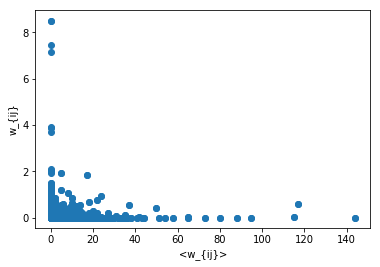

In [11]:
# plot wij_sample vs W
plt.scatter( np.log(wij_sample[:,:,0].flatten()), np.log(W.flatten() )) ; 
#plt.scatter( wij_sample[:,:,0].flatten(), W.flatten() ) ; 
plt.xlabel('w_{ij} sample')
plt.ylabel('w_{ij}')
#plt.xlim([0,0.2]); plt.ylim([0,2])
plt.show()

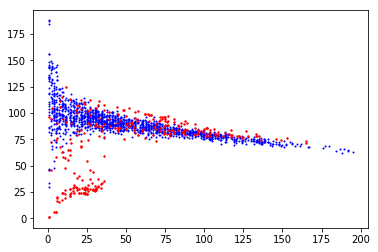

In [7]:
# k sample vs knn sample
plt.scatter(ki_sample[:,0:5].flatten(),knn_sample[:,0:5].flatten(),c='b',s=1)
plt.scatter(k,knn_, c='r',s=2 )
#plt.ylim([0,200])
plt.show()

 # UEGM+degree

UEGM utilise les $s_i$ pour fitter la topologie. 
Cela explique pourquoi le fit de $k^{nn}$ est mauvais.
Peut-on utiliser $k_i$ ?

# FiUGM data based ?

avec $f(d_{ij})$ comme dans [Expert et al] mais pour les $a_{ij}$ au lieu des $w_{ij}$ ?

A priori il suffit de remplacer $s_i$ par $k_i$ dans l'algo de Cazabet.

# Control variables

## spatial distance to center of network

cf [ESANN17](https://hal.archives-ouvertes.fr/hal-01649121)